In [ ]:
from google.colab import files
import zipfile
import os

uploaded = files.upload()

#Extract the zip file
with zipfile.ZipFile('/content/brisc2025.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/brisc2025_data')

print(os.listdir('/content/brisc2025_data'))

Saving brisc2025.zip to brisc2025.zip
['brisc2025']


In [ ]:
#preprocessing

from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (128, 128)
BATCH_SIZE = 32
VAL_SPLIT = 0.2
SEED = 42

TRAIN_DIR = '/content/brisc2025_data/brisc2025/classification_task/train'
TEST_DIR = '/content/brisc2025_data/brisc2025/classification_task/test'

#train: augmentation + rescale
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    zoom_range=0.10,
    horizontal_flip=True,
    validation_split=VAL_SPLIT
)

#val: rescale only
val_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=VAL_SPLIT
)

#test: rescale only
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True,
    seed=SEED,
    color_mode="rgb"
)

val_generator = val_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False,
    seed=SEED,
    color_mode="rgb"
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
    color_mode="rgb"
)

class_names = list(train_generator.class_indices.keys())
num_classes = train_generator.num_classes
print("Classes:", class_names)

import numpy as np
from collections import Counter

def print_class_counts(generator, set_name):

    #map the numbers (0,1,2,3) to the names
    class_labels = {v: k for k, v in generator.class_indices.items()}
    #count occurrences of each class index
    counts = Counter(generator.classes)

    print(f"\n {set_name} Class Breakdown")
    for index in sorted(counts.keys()):
        print(f"Class {index} ({class_labels[index]}): {counts[index]} images")

#run the count for all sets
print_class_counts(train_generator, "Training Set")
print_class_counts(val_generator, "Validation Set")
print_class_counts(test_generator, "Test Set")

Found 4002 images belonging to 4 classes.
Found 998 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']

 Training Set Class Breakdown
Class 0 (glioma): 918 images
Class 1 (meningioma): 1064 images
Class 2 (no_tumor): 854 images
Class 3 (pituitary): 1166 images

 Validation Set Class Breakdown
Class 0 (glioma): 229 images
Class 1 (meningioma): 265 images
Class 2 (no_tumor): 213 images
Class 3 (pituitary): 291 images

 Test Set Class Breakdown
Class 0 (glioma): 254 images
Class 1 (meningioma): 306 images
Class 2 (no_tumor): 140 images
Class 3 (pituitary): 300 images


In [ ]:
#handle class imbalance

from sklearn.utils.class_weight import compute_class_weight

y_train = train_generator.classes
class_weights_arr = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: w for i, w in enumerate(class_weights_arr)}
print("Class weights:", class_weights)

Class weights: {0: np.float64(1.0898692810457515), 1: np.float64(0.9403195488721805), 2: np.float64(1.1715456674473068), 3: np.float64(0.8580617495711835)}


In [ ]:
#The Advanced version separates Conv, BatchNormalization, and Activation to ensure
#the model stabilizes its math before detecting features, making it better at
#picking up subtle tumor textures that a standard CNN might miss.
#(finds feature, smooths/scales the data so it’s easy to read,Decides which parts of the "smooth" data are important)

from tensorflow.keras import layers, models

def build_advanced_resnet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    #initial feature extraction
    x = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    #residual layer (32 Filters)
    shortcut = x
    x = layers.Conv2D(32, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(32, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    #residual layer (64 Filters)
    #We use a 1x1 Conv on the shortcut to match the 64 filters
    shortcut = layers.Conv2D(64, (1, 1), padding='same')(x)

    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    #deeper features (128 Filters)
    shortcut = layers.Conv2D(128, (1, 1), padding='same')(x)

    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    x = layers.GlobalAveragePooling2D()(x) # better than flatten for good accuracy

    #final classification
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

#initialize the model
modela = build_advanced_resnet((128, 128, 3), 4)
modela.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
modela.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 128, 128,  │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 64, 64,    │      9,248 │ max_pooling2d_5[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 64, 64,    │      9,248 │ activation_1[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ add_4[0][0]       │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 32, 32,    │     36,928 │ activation_3[0][

 Total params: 194,564 (760.02 KB)

 Trainable params: 193,860 (757.27 KB)

 Non-trainable params: 704 (2.75 KB)

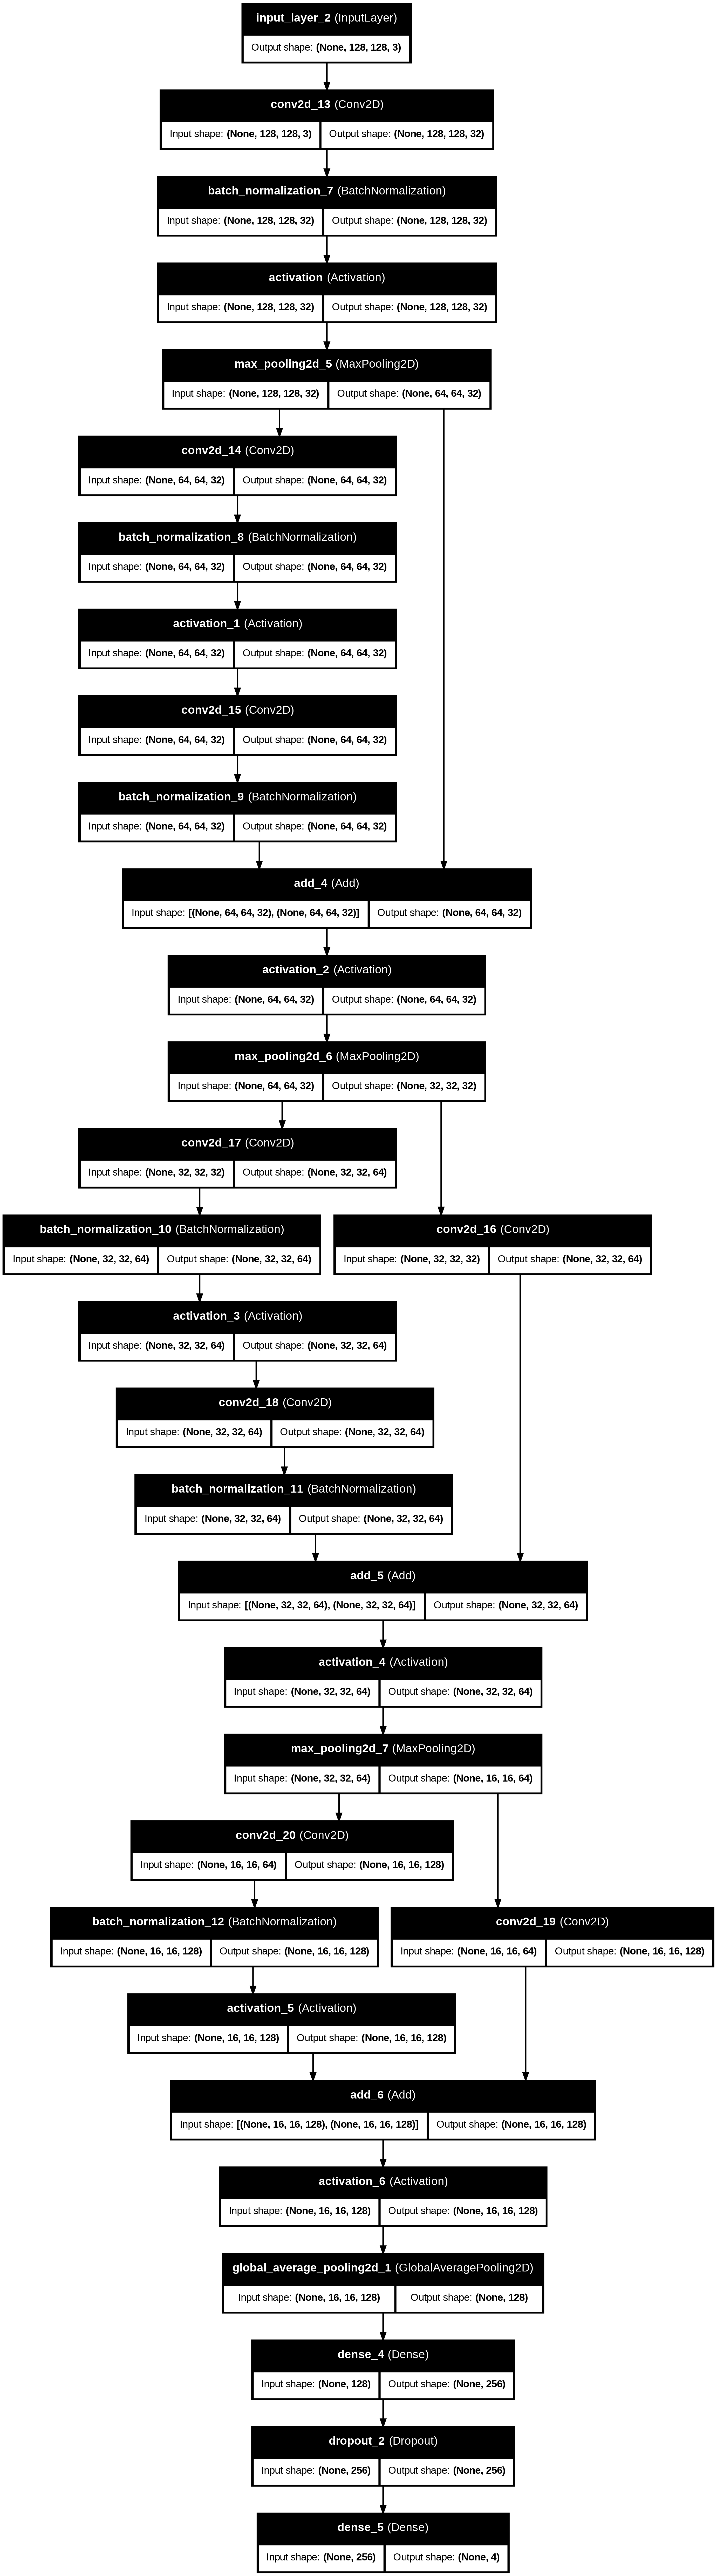

In [ ]:
import tensorflow as tf

tf.keras.utils.plot_model(modela, show_shapes=True, show_layer_names=True, to_file='build_advanced_resnet_architecture.png')

#display the image
from IPython.display import Image
Image('build_advanced_resnet_architecture.png')

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

#slow down the learning rate if accuracy stops improving (lr=0.001 default)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

#stop training if the model starts overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

callbacks_list = [reduce_lr, early_stop]


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

#slow down the learning rate if accuracy stops improving (lr=0.001 default)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

#stop training if the model starts overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

callbacks_list = [reduce_lr, early_stop]

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 109s 433ms/step - accuracy: 0.6135 - loss: 0.9768 - val_accuracy: 0.6924 - val_loss: 0.7422 - learning_rate: 1.0000e-04
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 27s 215ms/step - accuracy: 0.9039 - loss: 0.2771 - val_accuracy: 0.7846 - val_loss: 0.7300 - learning_rate: 1.0000e-04
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 28s 218ms/step - accuracy: 0.9236 - loss: 0.2080 - val_accuracy: 0.8156 - val_loss: 0.6652 - learning_rate: 1.0000e-04
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 27s 211ms/step - accuracy: 0.9524 - loss: 0.1410 - val_accuracy: 0.8687 - val_loss: 0.5792 - learning_rate: 1.0000e-04
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 27s 211ms/step - accuracy: 0.9497 - loss: 0.1348 - val_accuracy: 0.8677 - val_loss: 0.6592 - learning_rate: 1.0000e-04
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 29s 234ms/step - accuracy: 0.9665 - loss: 0.0946 - val_accuracy: 0.8657 - val_loss: 0.5930 - learning_rate: 1.000